# <center> Assignment 1: Toronto BikeShare and Weather Report Combined Analysis </center>
### <center> Samuel Vedrik, 25 January 2020 </center>

## Introduction

This report is part of an assignment for the JSC270 course at the University of Toronto. The data we will be using comes from the [Toronto Bikeshare Ridership open dataset](https://open.toronto.ca/dataset/bike-share-toronto-ridership-data/) and [Historical Weather Report](https://climate.weather.gc.ca/index_e.html). In this report, we will be answering three research questions. First, we will create two definitions for trip duration. We will find the relationship between these two different trip definitions. Secondly, we will find the relationship between "casual" and "member" users and their trip duration for both definitions. Third, we will utilize the weather report data and find correlations between the weather and trip durations. 


This report will be split into two parts: The preparation phase and the exploratory phase. 




**Dataset**

Both the Toronto Bikeshare Ridership and Historical Weather Report datasets are open for the public to use. According to the [Historical Weather Report terms and conditions](https://www.canada.ca/en/transparency/terms.html), we are allowed to use the dataset for non-commercial purposes, such as this report, granted that we do each of the following: 

* exercise due diligence in ensuring the accuracy of the materials reproduced
* indicate both the complete title of the materials reproduced, as well as the author (where available)
* indicate that the reproduction is a copy of the version available at \< URL where original document is available \>

(The above conditions are listed in the webpage linked above).

We cannot, however, use the given data for commercial purposes unless granted permission. Since this report will not be used for commercial purposes, we will proceed with using the dataset. 

We are also granted permission to use the dataset for Toronto BikeShare Ridership as stated in the [open data license](https://open.toronto.ca/open-data-license/). With this, we can begin the first part of the preparatory phase. 

For this analysis, we will use the 2016 Q3, Q4 and 2017 data from Toronto Bikeshare Ridership. We will also be using 2016 and 2017 data from the Historical Weather report. 

**Toronto Bikeshare Ridership**

We will begin by exploring the Toronto Bikeshare Ridership dataset and cleaning it. 

In [1]:
# All the imports that are necessary for this analysis. 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statistics as sta
import datetime as dt
import scipy.stats as stats

plt.rcParams['figure.figsize'] = [15, 7]
plt.style.use('ggplot')

In [2]:
# Import the datasets of the ridership data. 

df_2016q3 = pd.read_excel("data/2016_q3.xlsx")
df_2016q4 = pd.read_excel("data/2016_q4.xlsx")
df_2017q1 = pd.read_csv("data/2017_q1.csv")
df_2017q2 = pd.read_csv("data/2017_q2.csv")
df_2017q3 = pd.read_csv("data/2017_q3.csv")
df_2017q4 = pd.read_csv("data/2017_q4.csv")

We use the analysis provided by [this post](https://towardsdatascience.com/exploring-toronto-bike-share-ridership-using-python-3dc87d35cb62) to identify issues with this dataset. These are the following inconsistencies found: 

* Variation of the date time format. 
* Lack of station ID for Q3 and Q4
* Inconsistent station names
* Trips with very short/very long durations 
* Trips with the same from/to station. 
* Q1 and Q2 are in UTC timezone, Q3 and Q4 are in Eastern timezone.


Since this analysis will only deal with trip duration and user_type, we will ignore the issues that are related with station names/ID. We will use the following variables from the RideShare data: 

`["trip_start_time", "trip_stop_time", "trip_duration_seconds", "user_type"]`

We will first convert them to the datetime format. We will also look into removing erroneous data. We will consider trips that are less than 30 seconds long as invalid trips. Afterwards, we concatenate them into one large dataset. 

In [3]:
def fix_date_format(data, frmt):
    """
    A function to convert the data's trip start time to datetime.
    """
    data["trip_start_time"] = pd.to_datetime(data["trip_start_time"], format=frmt, errors="coerce")
    data["trip_stop_time"] = pd.to_datetime(data["trip_stop_time"], format=frmt, errors="coerce")
    
fix_date_format(df_2017q1, "%d/%m/%Y %H:%M")
fix_date_format(df_2017q2, "%d/%m/%Y %H:%M")
fix_date_format(df_2017q3, "%m/%d/%Y %H:%M")
fix_date_format(df_2017q4, "%m/%d/%y %H:%M:%S")



In [4]:
# Select only the relevant columns
rideshare_cols = ["trip_start_time", "trip_stop_time", "trip_duration_seconds", "user_type"]

df_2016q3 = df_2016q3[rideshare_cols].copy()
df_2016q4 = df_2016q4[rideshare_cols].copy()
df_2017q1 = df_2017q1[rideshare_cols].copy()
df_2017q2 = df_2017q2[rideshare_cols].copy()
df_2017q3 = df_2017q3[rideshare_cols].copy()
df_2017q4 = df_2017q4[rideshare_cols].copy()

In [5]:
# Remove errors
df_2016q3 = df_2016q3[df_2016q3["trip_duration_seconds"] >= 30].copy()
df_2016q4 = df_2016q4[df_2016q4["trip_duration_seconds"] >= 30].copy()
df_2017q1 = df_2017q1[df_2017q1["trip_duration_seconds"] >= 30].copy()
df_2017q2 = df_2017q2[df_2017q2["trip_duration_seconds"] >= 30].copy()
df_2017q3 = df_2017q3[df_2017q3["trip_duration_seconds"] >= 30].copy()
df_2017q4 = df_2017q4[df_2017q4["trip_duration_seconds"] >= 30].copy()

In [6]:
# Concatenate into one large data set
df_rideshare = pd.concat([df_2016q3, df_2016q4, df_2017q1, df_2017q2, df_2017q3, df_2017q4])
df_rideshare.reset_index(drop=True, inplace=True)
df_rideshare["trip_start_time"] = pd.to_datetime(df_rideshare["trip_start_time"])
df_rideshare["trip_stop_time"] = pd.to_datetime(df_rideshare["trip_stop_time"])

Lets perform some visual and quantitative analysis of this data. First, lets see the summary statistics of trip_duration_seconds.

In [7]:
df_rideshare.describe().astype(int)

,trip_duration_seconds
count,2051056
mean,1010
std,8361
min,30
25%,430
50%,668
75%,1032
max,6382030


There are some expected results, and some unexpected ones as well. The minimum is as expected, as we consider everything below 30 seconds are faulty data. However, the max is surprisingly large. We'll investigate this further. 

In [8]:
df_rideshare[df_rideshare["trip_duration_seconds"] == df_rideshare["trip_duration_seconds"].max()]

,trip_start_time,trip_stop_time,trip_duration_seconds,user_type
1274381,2017-08-03 15:37:00,2017-10-16 12:25:00,6382030,Casual


We discover that the max trip was over two months long! Although this might seem absurd, it is still beyond the realm of possibility. Therefore, for this analysis, I will opt to keep these outliers. Let's check the number of trips that are more than a day long:  

In [9]:
print("The percentage of rides longer than a day is: {:f}".format(
    (df_rideshare[df_rideshare["trip_duration_seconds"] >= 86400].shape[0]*100) / df_rideshare.shape[0]
     ))

The percentage of rides longer than a day is: 0.009264


The percentage is very small, so it is safe to keep them in the dataset. We will eliminate rides that are too long for when it is necessary to do so, i.e for distribution graphs. 

Next, let's take a look at the distribution of trip duration in seconds:

In [10]:
def get_smalls(data):
    """
    A function that returns a copy of the data set with observations that have a trip duration of 15000 or less.
    """
    return data[data["trip_duration_seconds"] <= 15000].copy()


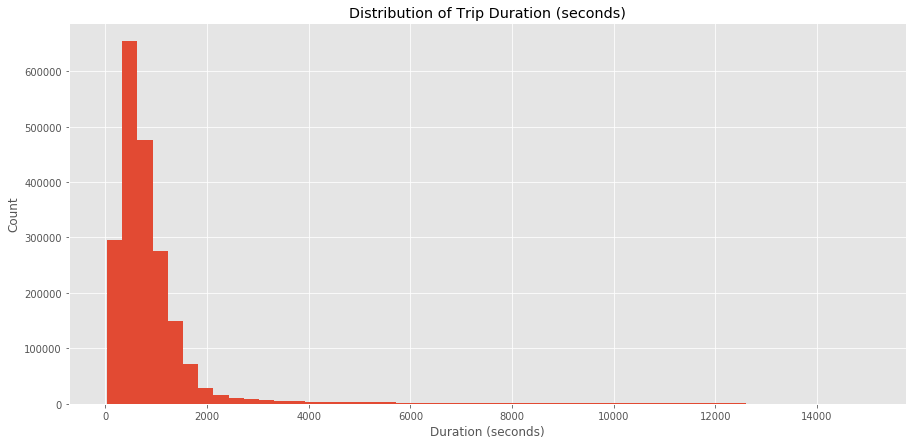

In [11]:
fig = get_smalls(df_rideshare).hist(bins=50)
title = plt.title("Distribution of Trip Duration (seconds)")
xlbl, ylbl = plt.xlabel("Duration (seconds)"), plt.ylabel("Count")

We can see that the median is somewhere in the range of 700-1000 seconds, and that the distribution tails off significantly after 2000. 

**Historical Weather Data**

Secondly, we will start by scraping the data provided by [this webpage](https://climate.weather.gc.ca/climate_data/daily_data_e.html?StationID=51459&timeframe=2&StartYear=1840&EndYear=2019&Day=1&Year=2017&Month=1) and similar pages.



In [12]:
URL = "https://climate.weather.gc.ca/climate_data/daily_data_e.html?StationID=51459" \
"&timeframe=2&StartYear=1840&EndYear=2019&Day=1"

append_format = "&Year={}&Month={}"

weather_dfs = {2016: [], 2017: []}

# Scrape data for 2016
for i in range(7, 13):
    df = (pd.read_html(URL+append_format.format(2016, i), header=0))[0][:-4]
    weather_dfs[2016].append(df)
    
# Scrape data for 2017
for i in range(1, 13):
    df = (pd.read_html(URL+append_format.format(2017, i), header=0))[0][:-4]
    weather_dfs[2017].append(df)
    

# Renames the columns into more appropiate names, and convert to numerical values.

col_name_map = {"DAY": "Day", "Max Temp Definition°C": "Max_Temp", "Min Temp Definition°C": "Min_Temp",
                "Mean Temp Definition°C": "Mean_Temp",
                "Heat Deg Days Definition": "Heat_Deg", "Cool Deg Days Definition": "Cool_Deg", 
                "Total Rain Definitionmm": "Total_Rain", "Total Snow Definitioncm": "Total_Snow",
               "Total Precip Definitionmm": "Total_Precip", "Snow on Grnd Definitioncm": "Ground_Snow", 
                "Dir of Max Gust Definition10's deg": "Dir_Wind",
                "Spd of Max Gust Definitionkm/h": "Max_Wind"}

# Renames the columns, and changes values to ints/floats.
for i in range(len(weather_dfs[2016])):
    weather_dfs[2016][i].rename(columns=col_name_map, inplace=True)
    weather_dfs[2016][i] = weather_dfs[2016][i].apply(pd.to_numeric, errors="ignore").copy()
    
for i in range(len(weather_dfs[2017])):
    weather_dfs[2017][i].rename(columns=col_name_map, inplace=True)
    weather_dfs[2017][i] = weather_dfs[2017][i].apply(pd.to_numeric, errors="ignore").copy()

We first identify columns that might have missing values across all the dataframes. 

In [13]:
col_with_na = []

# Get columns that have missing N/A
for dataframes in weather_dfs.values() :
    for dataframe in dataframes:
        col_with_na.extend(dataframe.columns[dataframe.isna().any(axis=0)].tolist())
        col_with_na = list(set(col_with_na))
    
print("The following columns have empty values:")
for col in col_with_na:
    print(col )

The following columns have empty values:
Ground_Snow
Dir_Wind


We won't be using the direction of the wind for this analysis, so we can safely drop it. Investigating the snow on ground column a little, I discovered that an empty cell can be represented as 0. Let us check the different non numerical values present in the "Ground_Snow" column. 

In [14]:
def get_non_numeric_values(column: str): 
    """
    Prints the unique non numeric values from a given column. 
    """
    col_values = []

    for dataframes in weather_dfs.values():
        for dataframe in dataframes:
#             col_values.extend(dataframe[column][~dataframe[column].apply(lambda x: type(x) == float)].unique())
            values = dataframe[column].unique()
            for value in values:
                if value is np.nan:
                    col_values.append(value)
                else:
                    try:
                        float(value)
                    except:
                        col_values.append(value)

    col_values = list(set(col_values))
        
    print("The following are the non numeric values present in {}: ".format(column))
    for item in col_values:
        print(item, end=" ")
        
    print("")
        
get_non_numeric_values("Ground_Snow")

The following are the non numeric values present in Ground_Snow: 
nan LegendTT 


As we can see, the values present are either numerical or "nan" and "LegendTT". LegendTT stands for trace, meaning that we can assume the value to be close to 0. For the purposes of this report, the value "LegendTT" and "nan" will be changed to 0. Let's analyze the other columns as well. 

In [15]:
for col in weather_dfs[2017][0].columns:
    get_non_numeric_values(col)

The following are the non numeric values present in Day: 

The following are the non numeric values present in Max_Temp: 
27.9LegendEE LegendMM 22.6LegendEE 
The following are the non numeric values present in Min_Temp: 
-1.2LegendEE 13.5LegendEE 8.5LegendEE 
The following are the non numeric values present in Mean_Temp: 
15.6LegendEE 20.7LegendEE LegendMM 
The following are the non numeric values present in Heat_Deg: 
2.4LegendEE 0.0LegendEE LegendMM 
The following are the non numeric values present in Cool_Deg: 
2.7LegendEE 0.0LegendEE LegendMM 
The following are the non numeric values present in Total_Rain: 
LegendTT LegendMM 
The following are the non numeric values present in Total_Snow: 
LegendTT LegendMM 
The following are the non numeric values present in Total_Precip: 
LegendTT LegendMM 0.0LegendEE 
The following are the non numeric values present in Ground_Snow: 
nan LegendTT 
The following are the non numeric values present in Dir_Wind: 
nan LegendMM 
The following are the n

From the above, we can deduce that there are the following non numeric values:

**1)** LegendMM, which means missing value

**2)** Number followed by LegendEE, which means estimated

**3)** LegendTT, which means trace

**4)** nan

**5)** <31


We will deal with the following differently: 

**1)** For missing values, we will just convert them to NaN. 

**2)** For LegendEE, we will just ignore it. 

**3)** For LegendTT, we will change the values to 0. 

**4)** For nan, we will change the values to 0. 

**5)** The <31 is only present for Max_Wind. Looking into the dataset, whenever Max_Wind is <31, there is no Dir_Wind. We can assume that this means that the wind is not strong enough for the sensor. For this analysis, we can set assume that they are 30. 

In [16]:
# Does the steps above 

for dataframes in weather_dfs.values():
    for dataframe in dataframes:
        dataframe.replace(regex={"LegendEE": "", "LegendTT": 0, "<31": 30}, inplace=True)
        dataframe.fillna(0, inplace=True)                                                 
        dataframe.replace(regex={"LegendMM": np.nan}, inplace=True)                       
        
for i in range(len(weather_dfs[2016])):
    weather_dfs[2016][i] = weather_dfs[2016][i].apply(pd.to_numeric, errors="ignore").copy()
    
for i in range(len(weather_dfs[2017])):
    weather_dfs[2017][i] = weather_dfs[2017][i].apply(pd.to_numeric, errors="ignore").copy()

In [17]:
# The following code is to check if there are any columns that are still the string datatype.
for dataframes in weather_dfs.values():
    for dataframe in dataframes:
        if (dataframe.dtypes == object).any():
            print("There are still strings!")

Finally, after cleaning the data, we can drop the wind direction column, add a date column, and concatenate them all together. 

In [18]:

for i in range(7, 13):
    weather_dfs[2016][i-7]["Date"] = 0
    for j in range(weather_dfs[2016][i-7].shape[0]):
        weather_dfs[2016][i-7].loc[j ,"Date"] = dt.date(year=2016, month=i, day=weather_dfs[2016][i-7]["Day"][j])
    weather_dfs[2016][i-7].drop(columns=["Dir_Wind", "Day"], inplace=True)

for i in range(1, 13):
    weather_dfs[2017][i-1]["Date"] = 0
    for j in range(weather_dfs[2017][i-1].shape[0]):
        weather_dfs[2017][i-1].loc[j, "Date"] = dt.date(year=2017, month=i, day=weather_dfs[2017][i-1]["Day"][j])
    weather_dfs[2017][i-1].drop(columns=["Dir_Wind", "Day"], inplace=True)
    
  

In [19]:
all_weather_dfs = []

for dataframes in weather_dfs.values():
    all_weather_dfs.extend(dataframes)
    
df_weather = pd.concat(all_weather_dfs)
df_weather.reset_index(drop=True, inplace=True)
df_weather["Date"] = pd.to_datetime(df_weather["Date"])

Lets perform some visual and descriptive analysis. 

In [20]:
df_weather.describe()

,Max_Temp,Min_Temp,Mean_Temp,Heat_Deg,Cool_Deg,Total_Rain,Total_Snow,Total_Precip,Ground_Snow,Max_Wind
count,548.000000,549.000000,548.000000,548.000000,548.000000,546.000000,547.000000,548.000000,549.000000,548.000000
mean,15.444343,6.375774,10.931569,8.517883,1.449453,1.962271,0.229433,2.175547,0.772313,44.551095
std,11.461728,9.771247,10.523301,8.911975,2.564934,5.083909,1.221163,5.180958,2.997730,13.692468
min,-14.500000,-22.600000,-18.600000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,30.000000
25%,5.875000,-0.200000,2.950000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,32.000000
50%,16.800000,6.900000,11.950000,6.050000,0.000000,0.000000,0.000000,0.000000,0.000000,43.000000
75%,25.625000,14.900000,20.300000,15.050000,2.300000,1.000000,0.000000,1.600000,0.000000,54.000000
max,36.000000,25.000000,30.500000,36.600000,12.500000,44.600000,15.600000,44.600000,19.000000,102.000000


From the above, we can from the count row that some columns have missing values. Going forward, we will just ignore days where data is missing, as there are still plenty of observations to use. 

In [21]:
print("There are {} days with missing values.".format(df_weather.isna().any(axis=1).sum()))

There are 4 days with missing values.


From the 75% quantile columns, we can deduce that most days don't encounter snow, and most days also don't encounter rain (there are less rainy days than there are non-rainy days). We also notice that the maximum value for Max_Wind is very high, at 102 KM/H. Let's investigate these days. 

In [22]:
df_weather[df_weather["Max_Wind"] == 102]

,Max_Temp,Min_Temp,Mean_Temp,Heat_Deg,Cool_Deg,Total_Rain,Total_Snow,Total_Precip,Ground_Snow,Max_Wind,Date
194,7.3,0.8,4.1,13.9,0.0,6.2,0.0,6.2,0.0,102.0,2017-01-11
471,24.4,7.5,16.0,2.0,0.0,7.8,0.0,7.8,0.0,102.0,2017-10-15


We can see from [this news report](https://globalnews.ca/news/3173901/strong-winds-bring-down-trees-causes-power-outages-across-the-greater-toronto-area) and [this other report](https://www.ctvnews.ca/canada/intense-ontario-storm-downs-trees-leaves-thousands-without-power-1.3633263) that these are not sensory errors, and that storms actually occured during these days. 

Let's look at the distribution of mean temperatures, and then the distribution of max wind speeds. These are the variables that I will hypothesize correlate with less bikeshare usage.  

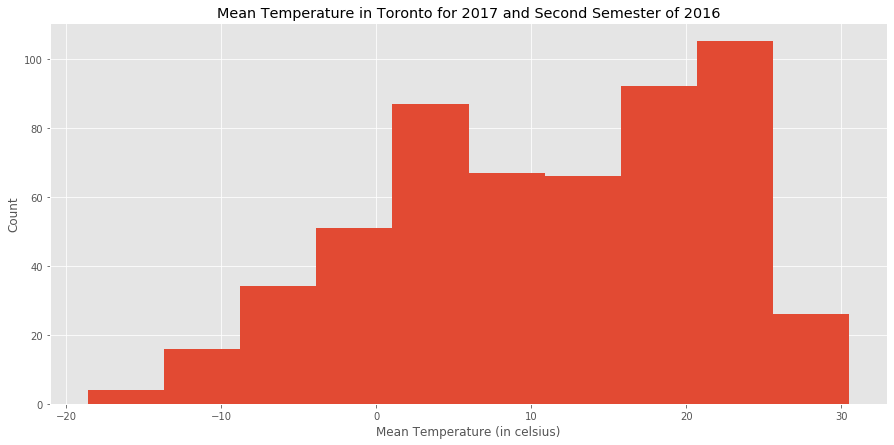

In [23]:
fig = df_weather["Mean_Temp"].hist()
title = plt.title("Mean Temperature in Toronto for 2017 and Second Semester of 2016")
xlbl, ylbl = plt.xlabel("Mean Temperature (in celsius)"), plt.ylabel("Count")

From the histogram above we can conclude that the distribution is bimodal. This is expected, as the seasons can be split into two: the "warmer" seasons and the "colder" seasons. The mean temperature for the colder seasons seem to be around 0-5 degrees, whereas the mean temperature for the warmer seasons seem to above 20. 

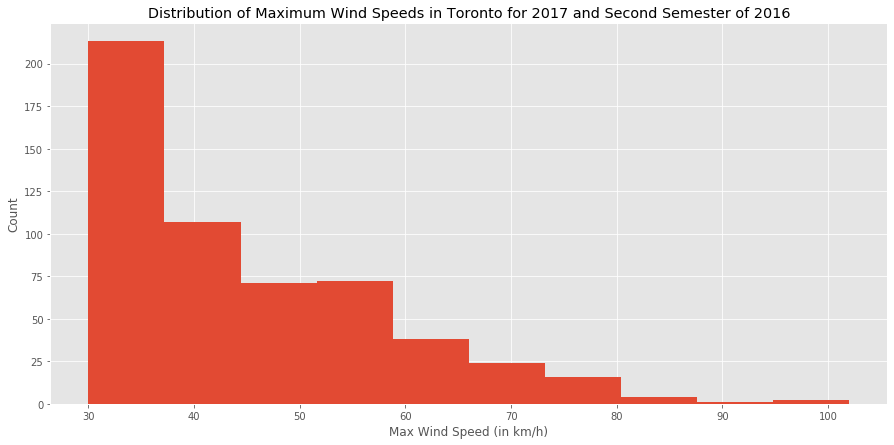

In [24]:
fig = df_weather["Max_Wind"].hist()
title = plt.title("Distribution of Maximum Wind Speeds in Toronto for 2017 and Second Semester of 2016")
xlbl, ylbl = plt.xlabel("Max Wind Speed (in km/h)"), plt.ylabel("Count")

From the histogram above, we can see that the distribution seems to be exponential. This makes logical sense: there are exponentially less days where the winds are strong. 

## Analysis

After exploring and cleaning the data, we can finally move to the analysis. We will split this section into three for the different questions we will answer. 

### Defining two different definitions of trip length

We will do this by creating two defintions of differing types. One will be categorical, and the other quantitative. 

The first quantitative definition is obvious: The trip length will be defined by using the trip_duration_seconds variable. This is quantitative as the trip duration is a continuous variable. 

The second will be a categorical definition as follows: Trip length is divided into three categories: Short, Medium, and Long. Short trips are defined as trips that are less than the 1st quartile, medium trips are defined as trips that are between the 1st quartile and 3rd quartile, and long trips are defined as trips that are greater than the 3rd quartile. 

We will create add a new variable to the data set to also include the second definition of trip duration. 

In [25]:
SHORT_BOUND = df_rideshare["trip_duration_seconds"].quantile(0.25)
LONG_BOUND = df_rideshare["trip_duration_seconds"].quantile(0.75)

def categorize_trip(x):
    """
    A function that returns whether the trip is short, medium, or long. 
    """
    if x < SHORT_BOUND:
        return "Short"
    elif x < LONG_BOUND:
        return "Medium"
    else:
        return "Long"
    
df_rideshare["trip_duration_cat"] = df_rideshare["trip_duration_seconds"].apply(categorize_trip)

In [26]:
df_rideshare.head()

,trip_start_time,trip_stop_time,trip_duration_seconds,user_type,trip_duration_cat
0,2016-07-09 01:03:00,2016-07-09 01:15:00,714,Member,Medium
1,2016-07-09 02:15:00,2016-07-09 02:22:00,417,Member,Short
2,2016-07-10 17:04:00,2016-07-10 17:36:00,1904,Member,Long
3,2016-07-11 01:45:00,2016-07-11 01:58:00,784,Member,Medium
4,2016-07-18 13:35:00,2016-07-18 13:42:00,443,Member,Medium


### Relationship between the two definitions

We will use an overlapping histogram to see the relation between the categorical and the quantitative variable. The correlation that "long" trips have the highest trip duration should be obvious, however the histogram allows us to also understand the distribution of each category. 

In [27]:
def get_smaller(data):
    """
    Returns a copy of the data where trip duration seconds is less than 4000. 
    """
    return data[data["trip_duration_seconds"] <= 4000].copy()

In [28]:
trip_dur_cat = [df_rideshare[df_rideshare["trip_duration_cat"] == "Short"],
                df_rideshare[df_rideshare["trip_duration_cat"] == "Medium"],
                df_rideshare[df_rideshare["trip_duration_cat"] == "Long"]
               ]

trip_dur_cat = [get_smaller(x).loc[:, "trip_duration_seconds"] for x in trip_dur_cat]


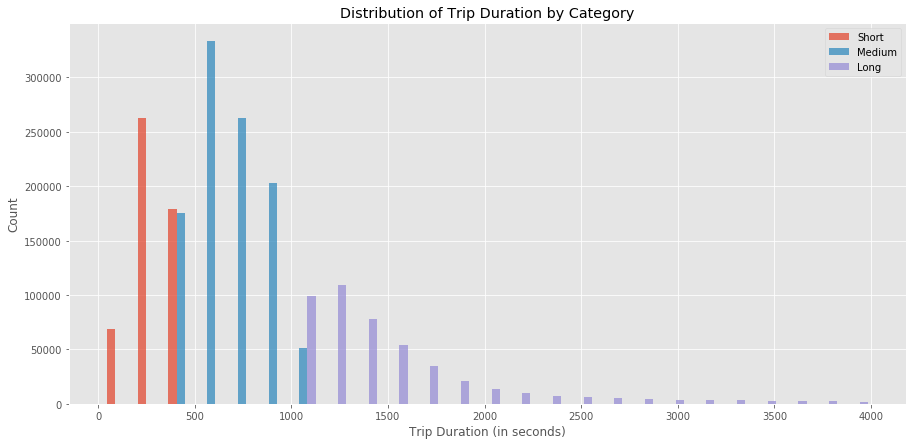

In [29]:
fig = plt.hist(trip_dur_cat, alpha=0.75, bins=25, label=["Short", "Medium", "Long"])
leg = plt.legend(loc=1)
title = plt.title("Distribution of Trip Duration by Category")
xlbl, ylbl = plt.xlabel("Trip Duration (in seconds)"), plt.ylabel("Count")


From the above histogram, we can see there is a relationship between the two defintions, as expected. Trips categorized as short have shorter trip durations, trips categorized as medium have average trip durations, and trips categorized as long have longer trip durations. 

It's interesting to note that the distribution of "long" trips seem to be less packed compared to the other two. Let's look a the summary statistics to confirm this.




In [30]:
get_smaller(df_rideshare).groupby("trip_duration_cat")["trip_duration_seconds"].describe().transpose().astype(int)

trip_duration_cat,Long,Medium,Short
count,461967,1026771,511486
mean,1519,687,297
std,545,167,89
min,1032,430,30
25%,1163,543,236
50%,1342,668,310
75%,1642,822,372
max,4000,1031,429


The standard deviation of "long" trips is significantly larger than the medium or short trips, and this confirms our observation. 

Equipped with these two definitions, lets tackle the remaining two analysis questions.

### Do casual members take shorter trips compared to members?

From the official toronto bikeshare [website](https://bikesharetoronto.com/pricing/), we can see that members get unlimited 30 minute rides for each day. Casual members are divided into several pricing tiers: 3 Day pass, Day pass and single trip. 

My hypothesis is that casual members do not take shorter trips compared to members, and in fact the opposite. Casual members may feel obliged to use up their 30 minute rides to get their money's worth, whereas members don't care as much as they get unlimited rides.

First, we will do this analysis using the first definition of trip length, trip duration seconds. 

First, lets compare summary statistics of the two members.

In [31]:
df_rideshare_casual = df_rideshare[df_rideshare["user_type"] == "Casual"]
df_rideshare_members = df_rideshare[df_rideshare["user_type"] == "Member"]

In [32]:
dfs_list = [df_rideshare_casual, df_rideshare_members]

summary = pd.concat([x.describe() for x in dfs_list], axis=1)
summary.columns=["Casual time duration", "Member time duration"]
summary.astype(int)

,Casual time duration,Member time duration
count,462295,1588761
mean,2117,688
std,16546,3183
min,30,30
25%,747,391
50%,1165,588
75%,1783,864
max,6382030,2312750


From the table above, we can see that the average trip duration is significantly higher for casual members than members. We can also see that the 2 month long trip that we discovered during the initial exploratory phase was in fact a casual member. The standard deviation for casual time is also significantly higher. This might be because the pricing tiers of 3 Day Pass, Day Pass, and Single Ride Passes are grouped into one. 

Let's plot the histograms for the two. 

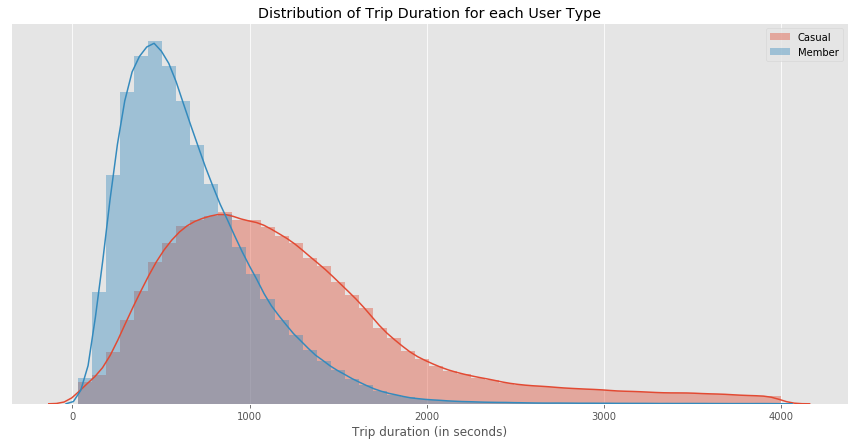

In [33]:
# plt.hist([get_smaller(x)["trip_duration_seconds"] for x in dfs_list], alpha = 0.5, label=["Casual", "Member"])

for item in [get_smaller(x) for x in dfs_list]:
    sns.distplot(item["trip_duration_seconds"], label=item["user_type"].iloc[0])

leg = plt.legend(loc=1)
title = plt.title("Distribution of Trip Duration for each User Type")
xlbl = plt.xlabel("Trip duration (in seconds)")
ytx = plt.yticks([])

The histogram above takes only into consideration trips that have a duration of 4000 or less to prevent the histogram to be overly skewed. 

We can see from the histogram above that members have a shorter trip duration than casual users, based on the location of the medians, as well as the larger number of trips above 2000 for casual members.  The variance of casual trip duration is also higher compared to members. Both distributions resemble a right skewed distribution. 


Now, lets use the second, categorical definition of trip length. 

In [34]:
summary2 = pd.concat([x["trip_duration_cat"].value_counts().sort_index(ascending=False) for x in dfs_list], axis = 1, ignore_index=True)
summary2.columns = ["Casual", "Member"]

In [35]:
summary2.head()

,Casual,Member
Short,36310,475176
Medium,159238,867533
Long,266747,246052


We can see that casual users have "long" trips as the mode, and members have "medium" trips as the node. It is also interseting to note that even though there are significantly less casual users than members, there are more casual members that take long trips compared to members. 

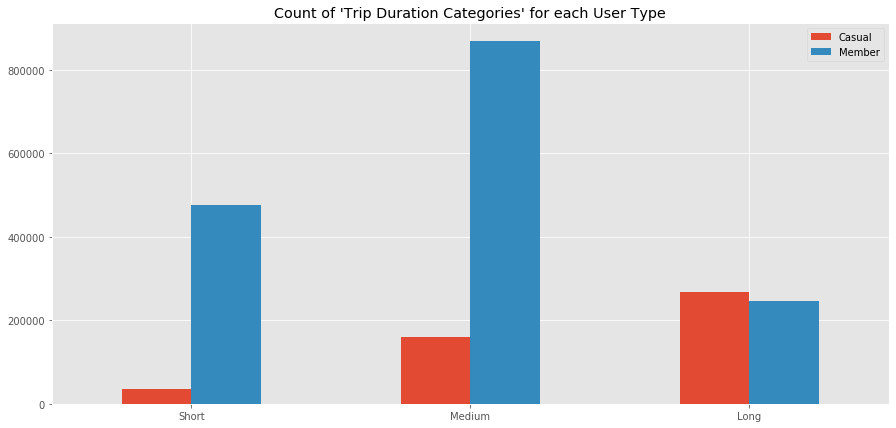

In [36]:
fig = summary2.plot.bar(rot=0)
fig.title.set_text("Count of 'Trip Duration Categories' for each User Type")

From the bar graph above, we can see more clearly that casual users have longer trips than short trips, whereas members tend to have either short or medium trips. 

The majority of short and medium trips are members, whereas the majority of long trips are casual users. 

In [37]:
summary2_2 = summary2.transpose()
summary2_2.iloc[0] = summary2_2.iloc[0].apply(lambda x: x/summary2_2.iloc[0].sum())
summary2_2.iloc[1] = summary2_2.iloc[1].apply(lambda x: x/summary2_2.iloc[1].sum())

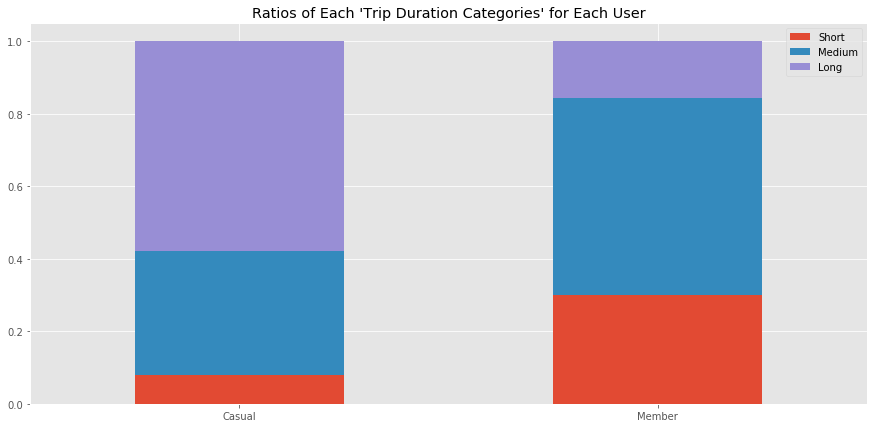

In [38]:
fig = summary2_2.plot.bar(stacked=True, rot=0)
title = plt.title("Ratios of Each 'Trip Duration Categories' for Each User")

The graph above shows more clearly that casual users take longer trips, as the majority of trips done by casual members are long. We can also see that members take more short/medium trips compared to long trips. 

**Conclusion**

From both of the analysis, it is safe to assume that our hypothesis is right, and that casual users take longer trips compared to members. Both definitions support the hypothesis. In fact, it is surprising how much longer casual users' trips are compared to members. 

## Does the weather affect trip length?


For this analysis, we will combine the weather data and the toronto ride share data. First, we have to combine the two datasets into a single dataframe for easier analysis. We will consider the trip start time as the date when the trip occured.  

We will first use the quantitative definition of trip duration first. 

We create a new dataframe with the additional info of average trip duration for that day. 

In the initial run for this analysis, it was discovered that creating this dataframe takes a very long time. After some investigation with timeit, it was discovered that on my machine it takes about 9 seconds per iteration, and there are almost 600 iterations. That amounts to roughly 1.5 hours to create the dataframe. This might be due to the fact that we have almost 2 million observations for the rideshare dataset, and filtering it for each day takes a long time. 

Therefore, to reduce the amount of time it takes for each iteration, we will be using a smaller sample of the data with size n = 100,000. 

This reduces the time it takes for each iteration to be about 500 ms. 

In [39]:
df_combined = df_weather.copy()

df_rideshare_small = df_rideshare.sample(100000, random_state=42)

In [40]:
# Get the mean trip duration, add into the dataframe

df_combined["Mean_trip_duration"] = 0
for i in range(df_combined.shape[0]):
    filter_ = df_rideshare_small["trip_start_time"].apply(lambda x: x.date()) == df_combined["Date"].iloc[i]
    result = df_rideshare_small[filter_]["trip_duration_seconds"].mean()
    df_combined.iloc[i, -1] = result

In [41]:
%%time
# This code is to time each iteration. 
filter_ = df_rideshare_small["trip_start_time"].apply(lambda x: x.date()) == df_combined["Date"].iloc[0]
result = df_rideshare_small[filter_]["trip_duration_seconds"].mean()
df_combined.iloc[0, -1] = result

CPU times: user 377 ms, sys: 2.43 ms, total: 379 ms
Wall time: 379 ms


In [42]:
df_analysis = df_combined.dropna()
df_analysis.head()

,Max_Temp,Min_Temp,Mean_Temp,Heat_Deg,Cool_Deg,Total_Rain,Total_Snow,Total_Precip,Ground_Snow,Max_Wind,Date,Mean_trip_duration
0,23.3,13.3,18.3,0.0,0.3,5.6,0.0,5.6,0.0,57.0,2016-07-01,1475.511364
1,26.4,12.3,19.4,0.0,1.4,0.0,0.0,0.0,0.0,57.0,2016-07-02,1415.851485
2,28.3,13.7,21.0,0.0,3.0,0.0,0.0,0.0,0.0,46.0,2016-07-03,1683.974576
3,28.9,14.7,21.8,0.0,3.8,0.0,0.0,0.0,0.0,30.0,2016-07-04,1119.058824
4,32.6,19.5,26.1,0.0,8.1,0.0,0.0,0.0,0.0,50.0,2016-07-05,862.129870


After dropping rows that contain NA, we finally have a dataframe to work with. Lets take a look of the distribution of the trip durations for the sample compared with the actual distribution of trip durations. 

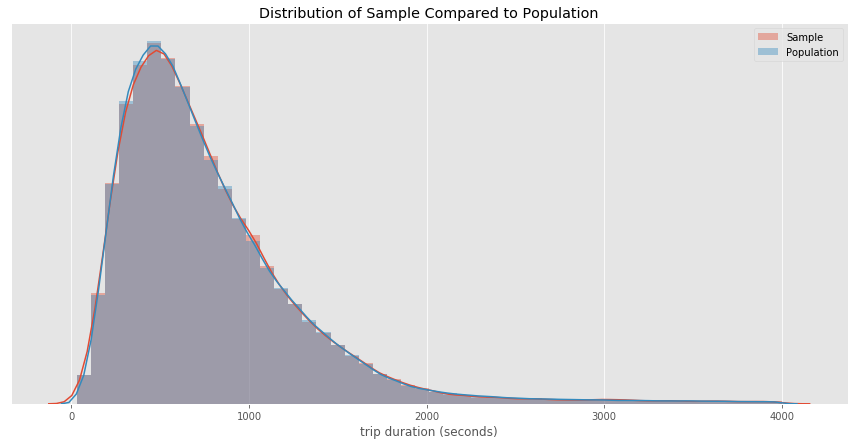

In [43]:
fig1 = sns.distplot(get_smaller(df_rideshare_small)["trip_duration_seconds"], label="Sample")
fig2 = sns.distplot(get_smaller(df_rideshare)["trip_duration_seconds"], label="Population")
title = plt.title("Distribution of Sample Compared to Population")
xlbl = plt.xlabel("trip duration (seconds)")
ytx = plt.yticks([])
leg = plt.legend(loc=1)

From the histogram above, we can conclude that the sample represents our population very well, and that the analysis with the sample generalize to the population. 

With this ease of mind, let's continue with the analysis. We will begin by plotting a scatter plot graph between mean temperatures and average trip duration. 

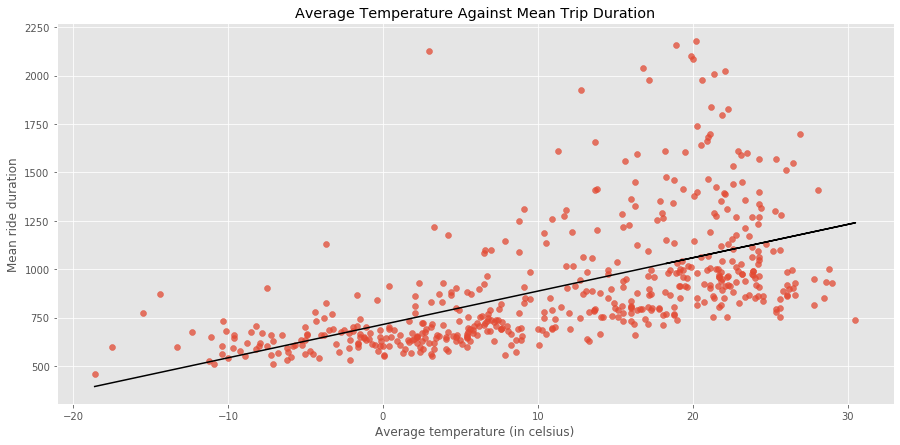

In [44]:
# For the regression fit line 
coef = np.polyfit(df_analysis["Mean_Temp"], df_analysis["Mean_trip_duration"], 1)
poly1_fn = np.poly1d(coef)

fig = plt.scatter(df_analysis["Mean_Temp"], df_analysis["Mean_trip_duration"], alpha=0.75)
fig2 = plt.plot(df_analysis["Mean_Temp"], poly1_fn(df_analysis["Mean_Temp"]), color="black")

title = plt.title("Average Temperature Against Mean Trip Duration")
xlbl, ylbl = plt.xlabel("Average temperature (in celsius)"), plt.ylabel("Mean ride duration")

We can see from the above that there seems to be a moderately strong positive correlation between mean temperature and the average trip duration. We can use the pearson r correlation coefficient to get a numerical score on the relationship:

In [45]:
def print_correlation(data1, data2):
    r_value = stats.pearsonr(data1, data2)[0]
    print("The correlation coefficient is: {:f}".format(r_value))

In [46]:
print_correlation(df_analysis["Mean_Temp"], df_analysis["Mean_trip_duration"])

The correlation coefficient is: 0.574671


The correlation coefficient is sufficiently high, and therefore we can safely conclude that as the mean temperature increases, the trip duration increases. This conclusion makes logical sense, as people would want to take longer rides during warmer weather. 

I notice how as the temperature reaches 30, the average ride duration looks like it starts to drop again. This also makes sense, as if the weather is too hot, then riding bikes is less feasable. Currently, there is not enough data for temperatures above 30 degrees celcius to make a conclusion. Let's hope it stays that way and we reverse climate change.

After walking home from campus and spotting a toronto hop-on hop-off bus, I wondered if the relationship between average temperature and trip duration is because there are more casual users during the warmer season (maybe due to tourists). Let's investigate this by grouping the datasets by members and casual users. 

In [47]:
df_split= df_weather.copy()

df_split["Mean_trip_duration"] = 0
df_split["Dominate"] = ""

for i in range(df_split.shape[0]):
    filter_ = df_rideshare_small["trip_start_time"].apply(lambda x: x.date()) == df_split["Date"].iloc[i]
    result = df_rideshare_small[filter_]["trip_duration_seconds"].mean()
    values = df_rideshare_small[filter_]["user_type"].value_counts()
    df_split.iloc[i, -2] = result
    try:
        df_split.iloc[i, -1] = "Casual" if values["Casual"] > values["Member"] else "Member"
    except:
        df_split.iloc[i, -1] = np.nan
    

In [48]:
df_split.head(2)

,Max_Temp,Min_Temp,Mean_Temp,Heat_Deg,Cool_Deg,Total_Rain,Total_Snow,Total_Precip,Ground_Snow,Max_Wind,Date,Mean_trip_duration,Dominate
0,23.3,13.3,18.3,0.0,0.3,5.6,0.0,5.6,0.0,57.0,2016-07-01,1475.511364,Member
1,26.4,12.3,19.4,0.0,1.4,0.0,0.0,0.0,0.0,57.0,2016-07-02,1415.851485,Casual


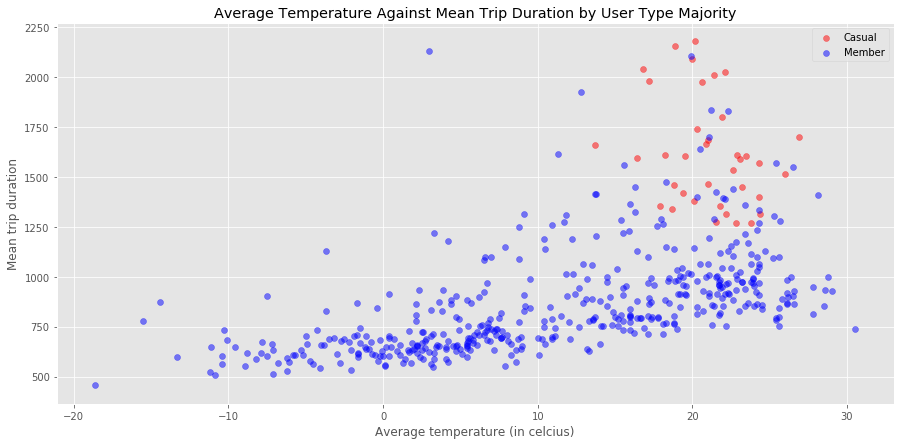

In [49]:
df_split_comp = df_split.dropna()
filter_ = df_split_comp["Dominate"] == "Member"
df_split_member = df_split_comp[filter_]
df_split_casual = df_split_comp[~filter_]

fig1 = plt.scatter(df_split_casual["Mean_Temp"], df_split_casual["Mean_trip_duration"], alpha=0.5, color="red", label="Casual")
fig2 = plt.scatter(df_split_member["Mean_Temp"], df_split_member["Mean_trip_duration"], alpha=0.5, color="blue", label="Member")
tit = plt.title("Average Temperature Against Mean Trip Duration by User Type Majority")
xlabel, ylabel = plt.xlabel("Average temperature (in celcius)"), plt.ylabel("Mean trip duration")
leg = plt.legend(loc=1)

In the graph above, each day is seperated into two different categories, "Casual" and "Member", depending on which user type has the majority for the day. We can see that in warmer temperatures, there are more casual users, and during days that casual users are the majority, the trip duration is longer. We can say that the influx of tourists might be a confounding variable, although there is not enough evidence to confidently say this. 

Next, let's take a look at the scatter plot between max wind speeds and average trip duration.

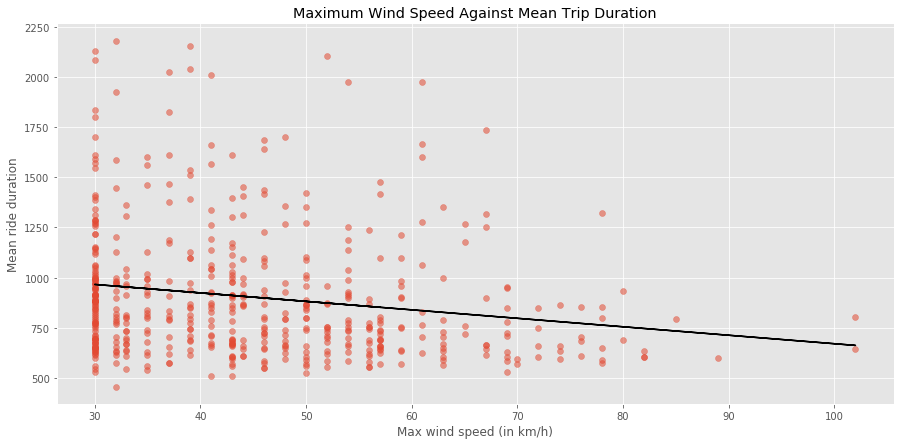

In [50]:
coef = np.polyfit(df_analysis["Max_Wind"], df_analysis["Mean_trip_duration"], 1)
poly1_fn = np.poly1d(coef)

fig = plt.scatter(df_analysis["Max_Wind"], df_analysis["Mean_trip_duration"], alpha=0.55)
fig2 = plt.plot(df_analysis["Max_Wind"], poly1_fn(df_analysis["Max_Wind"]), color="black")

tit = plt.title("Maximum Wind Speed Against Mean Trip Duration")
xlbl = plt.xlabel("Max wind speed (in km/h)")
ylbl = plt.ylabel("Mean ride duration")

We can see from above that there seems to be a weak negative correation between the two variables. This also makes logical sense, as during high wind speeds it is more dangerous to ride bicycles. An interesting observation is that during the two storm days, the average ride duration is non zero, implying that people rid their bikes in the middle of the storm.

Let's check the correlation coefficient of these two variables. 

In [51]:
print_correlation(df_analysis["Max_Wind"], df_analysis["Mean_trip_duration"])

The correlation coefficient is: -0.181789


As expected, the correlation is negative, and the absolute value is not very high, implying that it is a weak correlation. 

According to [this source](http://gyre.umeoce.maine.edu/data/gomoos/buoy/php/variable_description.php?variable=wind_2_speed) and [this source](https://www.weather.gov/dmx/dsswind), wind speeds above 30 mph (48 kmh) are considered strong winds. We will plot the scatter plot graph of mean temp and average trip duration again, and split it according to not strong winds (<48 kmh) and strong winds (>=48 kmh). 


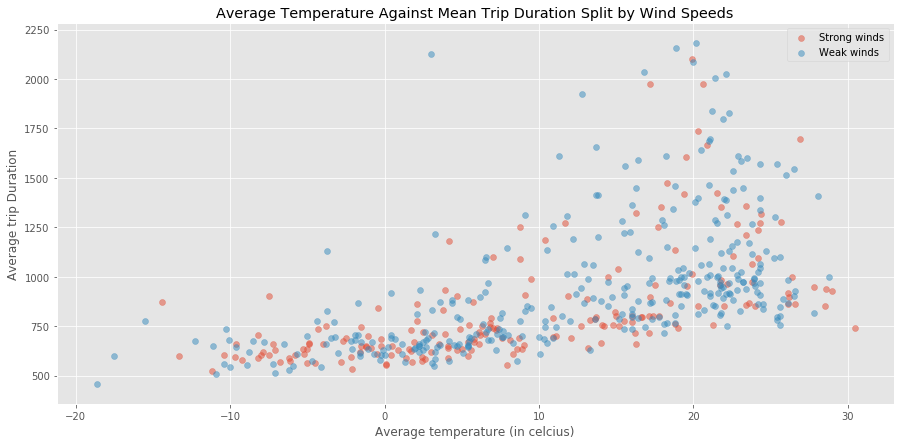

In [52]:
df_analysis_strong = df_analysis[df_analysis["Max_Wind"] >= 48].copy()
df_analysis_weak = df_analysis[df_analysis["Max_Wind"] < 48].copy()

fig = plt.scatter(df_analysis_strong["Mean_Temp"], df_analysis_strong["Mean_trip_duration"], alpha=0.5, label="Strong winds")
fig = plt.scatter(df_analysis_weak["Mean_Temp"], df_analysis_weak["Mean_trip_duration"], alpha=0.5, label="Weak winds")
leg = plt.legend(loc=1)

title = plt.title("Average Temperature Against Mean Trip Duration Split by Wind Speeds")
xlbl, ylbl = plt.xlabel("Average temperature (in celcius)"), plt.ylabel("Average trip Duration")

From the scatter plot above, we cannot divide the graph into obvious groups. This might indicate that there is little correlation between wind speeds and average temperature. Lets test this theory:

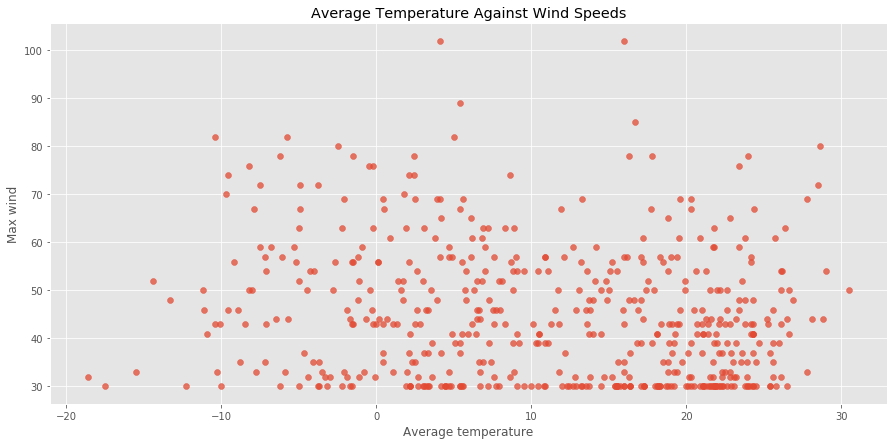

In [53]:
fig = plt.scatter(df_analysis["Mean_Temp"], df_analysis["Max_Wind"], alpha=0.75)
plt.title("Average Temperature Against Wind Speeds")
xlbl, ylbl = plt.xlabel("Average temperature"), plt.ylabel("Max wind")

From the graph above, we can see that is  little correlation between the two. We can see that wind speeds above 50 seem to be equally likely to be any temperature, and the same goes for wind speeds below 50. 

Next, lets perform the analysis using the categorical variable. 

First, we'll have to create a new dataframe similar to the first analysis. Instead of the mean trip duration, we will have 3 additional columns for a count of each category of the trip duration length: short, medium, long.

We will use the same sample that we acquired from the first part of this analysis. 

During the creation of the dataframe, there were some bugs that occured. After some investigation, it seems that on some days, there were no rides sampled. We will investigate this further. We will see if there are any rides on the population dataset on those dates. 


In [54]:
df_analysis_cat = df_weather.copy()
df_analysis_cat["Short"] = 0
df_analysis_cat["Medium"] = 0
df_analysis_cat["Long"] = 0

In [55]:
# From previous testing, the following values are the ones without any rides:
no_rides = [92, 93, 94, 95, 96, 97, 98, 99, 100, 123, 124, 125, 126, 127, 128, 129, 130, 131, 153, 154, 
           155, 156, 157, 158, 159, 160, 161]

filter_ = df_rideshare["trip_start_time"].apply(lambda x: x.date()) == df_analysis_cat["Date"].iloc[93]
print("There are {} rides on {}.".format(df_rideshare[filter_].shape[0], df_analysis_cat["Date"].iloc[93]))


There are 0 rides on 2016-10-02 00:00:00.


It seems like that there are no rides on some of the days. To counter this, whenever there are no rides, we will just set the rides to 0. 


In [56]:
for i in range(df_analysis_cat.shape[0]):
    filter_ = df_rideshare_small["trip_start_time"].apply(lambda x: x.date()) == df_analysis_cat["Date"].iloc[i]
    result = df_rideshare_small[filter_]["trip_duration_cat"].value_counts()
    try:
        df_analysis_cat.iloc[i, -3:] = [result["Short"], result["Medium"], result["Long"]]
    except:
        df_analysis_cat.iloc[i, -3:] = [0, 0 ,0]

In [57]:
%%time
filter_ = df_rideshare_small["trip_start_time"].apply(lambda x: x.date()) == df_combined["Date"].iloc[0]
result = df_rideshare_small[filter_]["trip_duration_cat"].value_counts()
df_analysis_cat.iloc[0, -3:] = [result["Short"], result["Medium"], result["Long"]]


CPU times: user 380 ms, sys: 2.22 ms, total: 382 ms
Wall time: 382 ms


In [58]:
df_analysis_cat.dropna(inplace=True)
df_analysis_cat.head()

,Max_Temp,Min_Temp,Mean_Temp,Heat_Deg,Cool_Deg,Total_Rain,Total_Snow,Total_Precip,Ground_Snow,Max_Wind,Date,Short,Medium,Long
0,23.3,13.3,18.3,0.0,0.3,5.6,0.0,5.6,0.0,57.0,2016-07-01,21,37,30
1,26.4,12.3,19.4,0.0,1.4,0.0,0.0,0.0,0.0,57.0,2016-07-02,14,48,39
2,28.3,13.7,21.0,0.0,3.0,0.0,0.0,0.0,0.0,46.0,2016-07-03,21,42,55
3,28.9,14.7,21.8,0.0,3.8,0.0,0.0,0.0,0.0,30.0,2016-07-04,31,76,29
4,32.6,19.5,26.1,0.0,8.1,0.0,0.0,0.0,0.0,50.0,2016-07-05,39,79,36


We can look at the summary statistics of the trip durations. 

In [59]:
df_analysis_cat.describe().iloc[:, -3:]

,Short,Medium,Long
count,545.000000,545.000000,545.000000
mean,43.957798,88.988991,44.458716
std,26.710665,56.960576,38.679331
min,0.000000,0.000000,0.000000
25%,25.000000,42.000000,12.000000
50%,40.000000,85.000000,35.000000
75%,61.000000,125.000000,66.000000
max,119.000000,247.000000,187.000000


As expected, the mean number of medium trips is double the mean number of short/long trips, due to its definition. We can safely assume that the distribution represents the population. 

Lets first take a look at scatter plot distribution between mean temperature and the ratio of the counts of each category of trip duration. 

In [60]:
def get_ratio(data):
    """
    Return a series that is the ratio of the category's count from total rides in a given day. 
    """
    return (data/df_analysis_cat.iloc[:, -3:].sum(axis=1)).fillna(0)

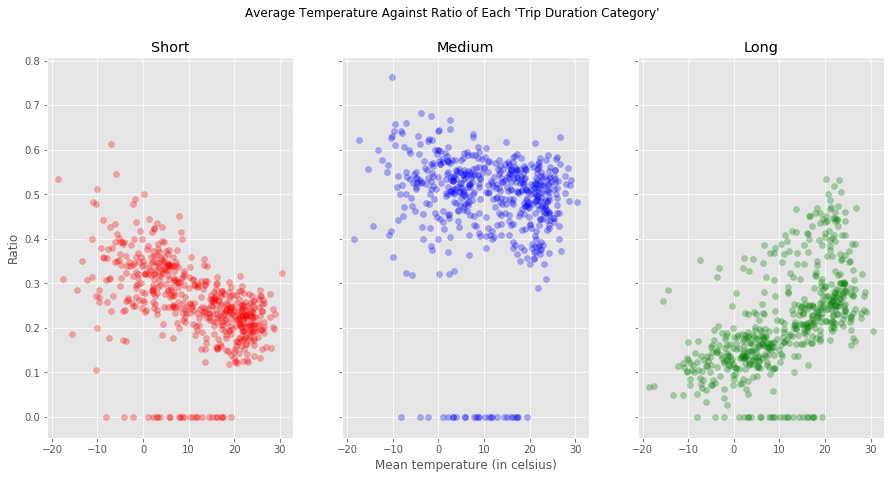

In [61]:
fig, axs = plt.subplots(1, 3, sharey=True)

axs[0].scatter(df_analysis_cat["Mean_Temp"], get_ratio(df_analysis_cat["Short"]), alpha=0.3, c="red")
axs[1].scatter(df_analysis_cat["Mean_Temp"], get_ratio(df_analysis_cat["Medium"]), alpha=0.3, c="blue")
axs[2].scatter(df_analysis_cat["Mean_Temp"], get_ratio(df_analysis_cat["Long"]), alpha=0.3, c="green")

axs[0].title.set_text("Short")
axs[1].title.set_text("Medium")
axs[2].title.set_text("Long")

axs[1].set(xlabel="Mean temperature (in celsius)")
axs[0].set(ylabel="Ratio")

title = fig.suptitle("Average Temperature Against Ratio of Each 'Trip Duration Category'")

We can see from the graphs above several observations:

* The ratio of short trips decreases as the temperature increases
* The ratio of medium trips stay roughly consistent as the temperature increases
* The ratio of long trips increases as the temperature increases

The correlations for each of them is quite strong. We can test this using the pearson r correlation coefficient.

In [62]:
print("For short trips:")
print_correlation(df_analysis_cat["Mean_Temp"], get_ratio(df_analysis_cat["Short"]))
print("For medium trips:")
print_correlation(df_analysis_cat["Mean_Temp"], get_ratio(df_analysis_cat["Medium"]))
print("For long trips:")
print_correlation(df_analysis_cat["Mean_Temp"], get_ratio(df_analysis_cat["Long"]))

For short trips:
The correlation coefficient is: -0.467154
For medium trips:
The correlation coefficient is: -0.084760
For long trips:
The correlation coefficient is: 0.585962


From the values of the correlation coefficients above, we can say that the the correlation is moderately strong.

Next, we take a look at the relationship between max winds and the ratio of the counts of each category of trip duration. 

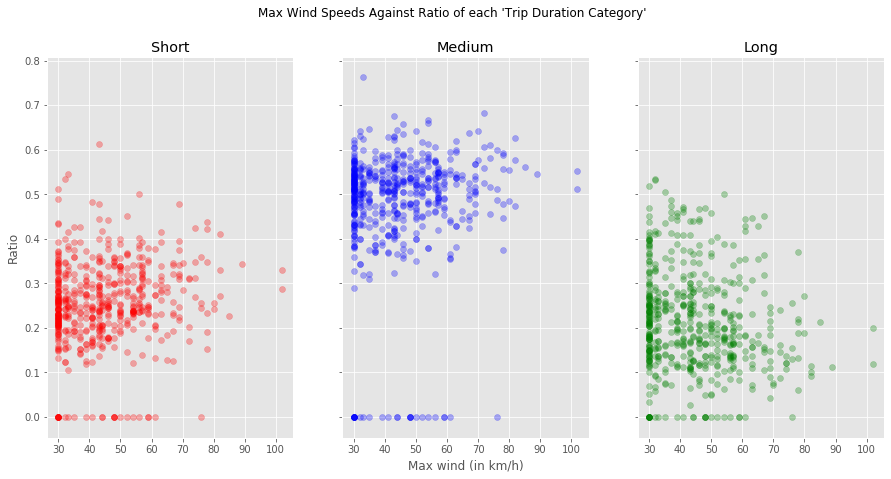

In [63]:
fig, axs = plt.subplots(1, 3, sharey=True)

axs[0].scatter(df_analysis_cat["Max_Wind"], get_ratio(df_analysis_cat["Short"]), alpha=0.3, c="red")
axs[1].scatter(df_analysis_cat["Max_Wind"], get_ratio(df_analysis_cat["Medium"]), alpha=0.3, c="blue")
axs[2].scatter(df_analysis_cat["Max_Wind"], get_ratio(df_analysis_cat["Long"]), alpha=0.3, c="green")

axs[0].title.set_text("Short")
axs[1].title.set_text("Medium")
axs[2].title.set_text("Long")

axs[1].set(xlabel="Max wind (in km/h)")
axs[0].set(ylabel="Ratio")

title = fig.suptitle("Max Wind Speeds Against Ratio of each 'Trip Duration Category'")

We can see from the graphs above that the relationship is harder to see for each of the categories. However, the ratios seem to roughly stay the same. We can check this with the correlation coefficients:

In [64]:
print("For short trips:")
print_correlation(df_analysis_cat["Max_Wind"], get_ratio(df_analysis_cat["Short"]))
print("For medium trips:")
print_correlation(df_analysis_cat["Max_Wind"], get_ratio(df_analysis_cat["Medium"]))
print("For long trips:")
print_correlation(df_analysis_cat["Max_Wind"], get_ratio(df_analysis_cat["Long"]))

For short trips:
The correlation coefficient is: 0.122902
For medium trips:
The correlation coefficient is: 0.084008
For long trips:
The correlation coefficient is: -0.155671


From the correlation coefficients above, the correlation is very little, if any. We can see that as wind speeds increase, the ratio of short trips roughly increase, and the ratio of long trips roughly decrease. 

**Conclusion** 

From both the analyses, we can conclude that the mean temperature has a considerable affect on trip duration. Both analyses show that the correlation between tempeture and trip duration is strong, so we can safely say that there is strong evidence showing that warmer the weather, the longer the trip duration is.

This conclusion was not surprising, as it makes sense that the warmer the weather, the more likely people are to go out of their houses, and vice versa. That has a direct impact on the length of the trips. 

We can also conclude, albeit with less confidence, that as wind speeds increase, the trip durations decrease. The correlation coefficients are less strong, so therefore we conclude that there is weak evidence showing that the stronger the winds, the shorter the trip duration is. 

This conclusion is not suprising, however the degree of confidence is. I was expecting wind speeds to play a bigger role for trip duration, as the stronger the winds the more dangerous it is to ride bicycles. However, the evidence shows that the correlation is rather weak. 

## Final thoughts

From this analysis, we have learned the following things: 

* Casual users take longer trips than members.
* The warmer it is, the longer trips people take.
* The above might be due to there being more tourists in the warmer seasons.
* If the temperature is too hot, people might take shorter trips.
* The stronger the winds, the shorter trips people take. 

These are the limitations of this analysis:
  
1) We did not take into consideration the location of the rides. This can be a future improvement to this analysis, as there might be areas where winds/weather matter less, or areas with more casual users, such as popular tourist places like Union station. 

2) For the analysis regarding the weather, we used a sample that is 5% the size of the original dataset. This might cause some issues in the analysis that was not discovered. 

3) There were unexplained missing information for some of the dates. Shallow research has not been able to find the cause for this. 

Thank you for taking the time to read this analysis. 
